<a href="https://colab.research.google.com/github/harshad291004/Fake-news-Detector/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import csv
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Bidirectional, GRU

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--2025-07-29 12:35:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-29 12:35:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-29 12:35:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

gl

In [ ]:
fake_df = pd.read_csv('/content/Fake.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE, encoding='utf-8')
real_df = pd.read_csv('/content/True.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE, encoding='utf-8')

fake_df['label'] = 1
real_df['label'] = 0

df = pd.concat([fake_df[['title', 'text', 'label']], real_df[['title', 'text', 'label']]], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
df.dropna(inplace=True)

print("Dataset size:", df.shape)
df.head()


In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = str(text).lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)
df[['text', 'clean_text']].head()


,text,clean_text
46,worldnews,worldnew
56,"""Sep 11",sep 11
284,"2015""",2015
332,"2017""",2017
403,"2015""",2015


In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['label'].values

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf = logreg_model.predict(X_test_tfidf)

print("TF-IDF + Logistic Regression Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test_tfidf, y_pred_tfidf))


TF-IDF + Logistic Regression Accuracy: 0.8368794326241135

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.49      0.63        41
           1       0.82      0.98      0.89       100

    accuracy                           0.84       141
   macro avg       0.87      0.73      0.76       141
weighted avg       0.85      0.84      0.82       141



In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=300)

X = padded
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=300))
model.add(GRU(64))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
embedding_index = {}
with open('glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
embedding_dim = 200
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=300,
                    trainable=True))

model.add(GRU(128))

model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,200 (51.56 KB)

 Trainable params: 13,200 (51.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5812 - loss: 0.6753 - val_accuracy: 0.7092 - val_loss: 0.5544
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6681 - loss: 0.5977 - val_accuracy: 0.7092 - val_loss: 0.5222
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6951 - loss: 0.5551 - val_accuracy: 0.7092 - val_loss: 0.4980
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6838 - loss: 0.5303 - val_accuracy: 0.7943 - val_loss: 0.4795
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7168 - loss: 0.4883 - val_accuracy: 0.7872 - val_loss: 0.4550
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7475 - loss: 0.4713 - val_accuracy: 0.8085 - val_loss: 0.4303
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8035 - loss: 0.4315 - val_accuracy: 0.8369 - val_loss: 0.4089
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8132 - loss: 0.4082 - val_accuracy: 0.8511 - val_loss: 0.3882
Epoch 9/15
5

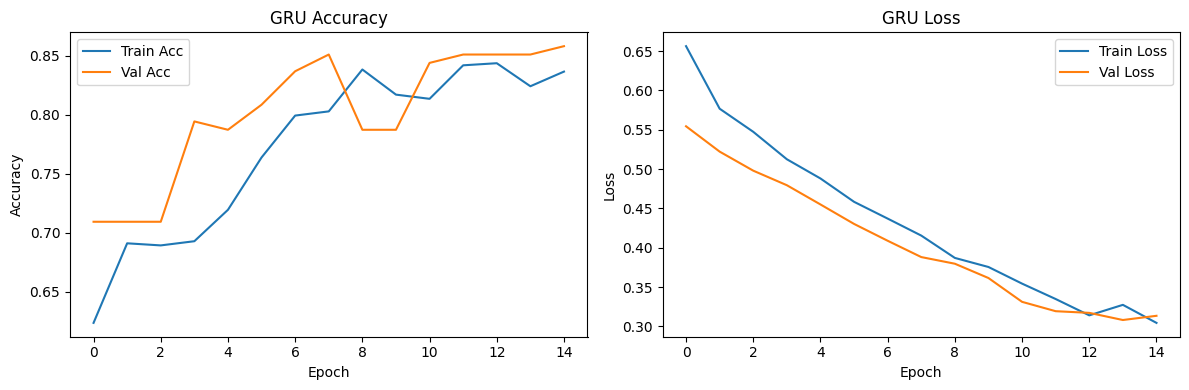

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
gru_loss, gru_accuracy = model.evaluate(X_test, y_test)
print("GRU Accuracy:", gru_accuracy)

tfidf_accuracy = accuracy_score(y_test_tfidf, y_pred_tfidf)
print("Model Comparison:")
print(f"TF-IDF + Logistic Regression Accuracy: {tfidf_accuracy:.4f}")
print(f"GRU + GloVe Accuracy: {gru_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8755 - loss: 0.2950
GRU Accuracy: 0.8581560254096985
Model Comparison:
TF-IDF + Logistic Regression Accuracy: 0.8369
GRU + GloVe Accuracy: 0.8582


In [ ]:
gru_loss, gru_accuracy = model.evaluate(X_test, y_test)
print("GRU Accuracy:", gru_accuracy)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.8478 - loss: 0.3087
GRU Accuracy: 0.8297872543334961


In [ ]:
tfidf_accuracy = accuracy_score(y_test_tfidf, y_pred_tfidf)

print("Model Comparison:")
print(f"TF-IDF + Logistic Regression Accuracy: {tfidf_accuracy:.4f}")
print(f"GRU Accuracy: {gru_accuracy:.4f}")


Model Comparison:
TF-IDF + Logistic Regression Accuracy: 0.8369
GRU Accuracy: 0.8298


In [ ]:
def predict_news(text, method='gru'):
    processed = preprocess(text)

    if method == 'tfidf':
        vectorized = tfidf.transform([processed])
        prediction = logreg_model.predict(vectorized)
        return "FAKE" if prediction[0] == 1 else "REAL"

    elif method == 'gru':
        seq = tokenizer.texts_to_sequences([processed])
        padded_seq = pad_sequences(seq, maxlen=300)
        prediction = model.predict(padded_seq)
        return "FAKE" if prediction[0][0] > 0.5 else "REAL"
    else:
        return "Invalid method specified."

print(predict_news("Modi is the president of India.", method='gru'))
print(predict_news("NASA launches new rover to Mars", method='tfidf'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
FAKE
FAKE
